In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from salishsea_tools import bathy_tools
from salishsea_tools import nc_tools

In [2]:
bathy = nc.Dataset('../../nemo-forcing/grid/bathy_meter_SalishSea6.nc', 'r')
print bathy.file_format
print bathy.variables.keys

NETCDF4
<bound method OrderedDict.keys of OrderedDict([(u'nav_lon', <netCDF4.Variable object at 0x7f344c16af28>), (u'nav_lat', <netCDF4.Variable object at 0x7f3431774180>), (u'Bathymetry', <netCDF4.Variable object at 0x7f3431774218>)])>


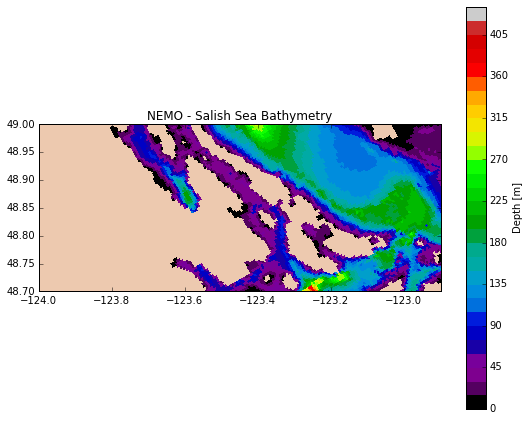

In [5]:
fig = bathy_tools.plot_colourmesh(
    bathy, 'NEMO - Salish Sea Bathymetry', 
    axis_limits=(-124, -122.9, 48.7, 49), colour_map='spectral', bins=30)

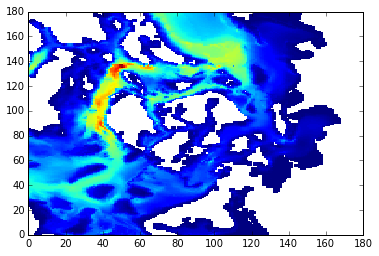

In [31]:
imin = 220
imax = 380
jmin = 210
jmax = 370
depths = bathy.variables['Bathymetry'][:]
plt.pcolormesh(depths[imin-10:imax+10, jmin-10:jmax+10])

In [44]:
new_depths = np.copy(depths)
mask = depths > 0
notmask = depths == 0
new_depths[imin:imax, jmin:jmax] = new_depths[imin:imax, jmin:jmax] + 10 * mask[imin:imax, jmin:jmax] 
new_depths_masked = np.ma.array(new_depths, mask=notmask)

<matplotlib.colorbar.Colorbar instance at 0x7f3427f5af80>

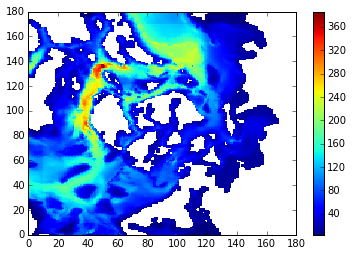

In [45]:
plt.pcolormesh(new_depths_masked[imin-10:imax+10, jmin-10:jmax+10])
plt.colorbar()

In [46]:
# lets smooth
max_dh_over_hbar = 0.8
depthsmooth = bathy_tools.smooth(new_depths_masked[:], max_norm_depth_diff=max_dh_over_hbar, smooth_factor=0.2)

<matplotlib.colorbar.Colorbar instance at 0x7f3427d60758>

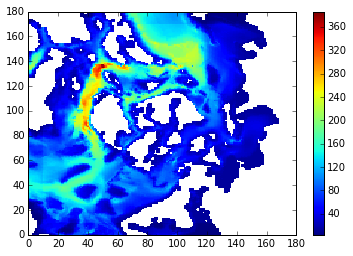

In [47]:
plt.pcolormesh(depthsmooth[imin-10:imax+10, jmin-10:jmax+10])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f3427784c68>

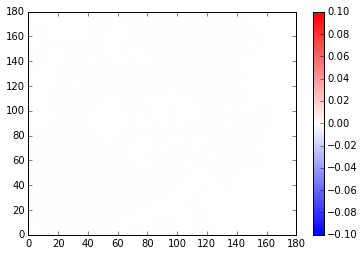

In [51]:
plt.pcolormesh(depthsmooth[imin-10:imax+10, jmin-10:jmax+10]-new_depths_masked[imin-10:imax+10, jmin-10:jmax+10], cmap = 'bwr')
plt.colorbar()

In [58]:
ysize = depthsmooth.shape[0]; xsize = depthsmooth.shape[1]
print ysize, xsize

new_bathy = nc.Dataset('bathy_depthHaroBoundary.nc', 'w')
new_bathy.createDimension('y', ysize)
new_bathy.createDimension('x', xsize)
nc_tools.show_dimensions(new_bathy)

898 398
<type 'netCDF4.Dimension'>: name = 'y', size = 898

<type 'netCDF4.Dimension'>: name = 'x', size = 398



In [59]:
newlons = new_bathy.createVariable('nav_lon', float, ('y', 'x'), zlib=True)
newlons.setncattr('units', 'degrees_east')
newlats = new_bathy.createVariable('nav_lat', float, ('y', 'x'), zlib=True)
newlats.setncattr('units', 'degrees_north')
newdepths = new_bathy.createVariable(
    'Bathymetry', float, ('y', 'x'), 
    zlib=True, least_significant_digit=0.1, fill_value=0)
newdepths.setncattr('units', 'metres')

newlons[:] = bathy.variables['nav_lon']
newlats[:] = bathy.variables['nav_lat']
newdepths[:] = depthsmooth[:]

In [60]:
nc_tools.show_dataset_attrs(new_bathy)

file format: NETCDF4


In [55]:
print bathy.history


    [2013-10-30 13:18] Created netCDF4 zlib=True dataset.
    [2013-10-30 15:22] Set depths between 0 and 4m to 4m and those >428m to 428m.
    [2013-10-31 17:10] Algorithmic smoothing.
    [2013-11-21 19:53] Reverted to pre-smothing dataset (repo rev 3b301b5b9b6d).
    [2013-11-21 20:14] Updated dataset and variable attributes to CF-1.6 conventions & project standards.
    [2013-11-21 20:47] Removed east end of Jervis Inlet and Toba Inlet region due to deficient source bathymetry data in Cascadia dataset.
    [2013-11-21 21:52] Algorithmic smoothing.



In [61]:
new_bathy.history = """
[2013-10-30 13:18] Created netCDF4 zlib=True dataset.
[2013-10-30 15:22] Set depths between 0 and 4m to 4m and those >428m to 428m.
[2013-10-31 17:10] Algorithmic smoothing.
[2013-11-21 19:53] Reverted to pre-smothing dataset (repo rev 3b301b5b9b6d).
[2013-11-21 20:14] Updated dataset and variable attributes to CF-1.6 conventions & project standards.
[2013-11-21 20:47] Removed east end of Jervis Inlet and Toba Inlet region due to deficient source bathymetry data in Cascadia dataset.
[2013-11-21 21:52] Algorithmic smoothing.
[2014-01-01 14:44] Smoothed mouth of Juan de Fuca
[2015-] Jie made Fraser River
[2015-12-24 11:46] Deepened Haro/Boundary Region by 10 m, smoothed to 0.8
"""

In [62]:
new_bathy.conventions = """
CF-1.6"""

new_bathy.title= """
Salish Sea NEMO Bathymetry"""

new_bathy.institution= """ 
Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia"""

new_bathy.references= """ 
https://bitbucket.org/salishsea/nemo-forcing/src/tip/grid/bathy_depthBoundaryHaro.nc"""

new_bathy.comment= """
Based on 1_bathymetry_seagrid_WestCoast.nc file from 2-Oct-2013 WCSD_PREP tarball provided by J-P Paquin.
"""

new_bathy.source= """ 
https://bitbucket.org/salishsea/tools/src/tip/bathymetry/SalishSeaBathy.ipynb
https://bitbucket.org/salishsea/tools/src/tip/bathymetry/SmoothMouthJdF.ipynb
https://bitbucket.org/salishsea/tools/src/tip/bathymetry/Deepen Haro Boundary Region.ipynb
"""

new_bathy.close()